In [1]:
import cv2

In [179]:
def add_raze(im, x, y, size):
    assert x-size/2 >= 0 and x+size/2 <= im[0].size and y-size/2 >= 0 and y+size/2 <= im[1].size
    raze = cv2.imread("Characters/Raze.png")[:, :, ::-1]
    raze = cv2.resize(raze, (size, size))
    im[x-size//2 : x+size//2, y-size//2 : y+size//2, :] = raze
    return im

In [185]:
adds = [add_raze]

In [180]:
haven = cv2.imread("Maps/Haven.png")

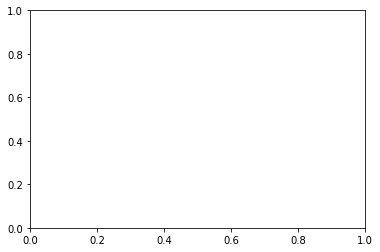

In [181]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

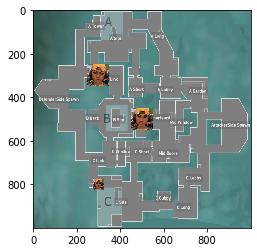

In [184]:
plt.imshow(add_raze(haven, 800, 300, 50))

TypeError: add_raze() missing 4 required positional arguments: 'im', 'x', 'y', and 'size'